In [1]:

#* Dane 30tyś iteracji
#* Wystapienie awarii po 20tyś iteracji
    
#* Wen, Qingsong, et al. "Transformers in Time Series: A Survey." arXiv preprint arXiv:2202.07125 (2022).
#* https://arxiv.org/pdf/2202.07125.pdf

#* Online Machine Learning
#* https://analyticsindiamag.com/how-to-learn-from-streaming-data-with-creme-in-python/

#* Timeseries Forecasting
#* https://www.tensorflow.org/tutorials/structured_data/time_series

In [2]:

#* Czy każdy model powinien być wyuczony dla jednego połączenia

#* Czy w ramach predykcji powinniśmy analizować działanie także model zaczyna predykcje od N ostatnich próbek

#* Następnie w każdym kolejnym kroku wykorzystuje poprzednie N-1 próbek oraz ostatnio przewidzianą próbkę
#* W ten sposób po N krokach każda kolejna predykcja będzie wykonywana na podstawie jedynie przewidzianych próbek
#* Bez udziału próbek realnych

In [3]:
# Utility imports
import os
import tqdm
from collections import defaultdict

# Math and matrix manipulation imports
import numpy as np
import pandas as pd

# Graphing imports
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
# Tensorflow required
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [53]:
DATA_PATH = "./traffic/"
# Lista pozwalajaca zobaczyc skladowe generowanego sygnalu
list_of_datafiles = os.listdir(DATA_PATH)
#list_of_datafiles = sorted([int(x.replace('.txt', '')) for x in list_of_datafiles])

In [71]:
df = defaultdict(list)

# TODO: Zmienic w funkcje
# TODO: Dodac multiprocessing
for file in tqdm.tqdm(list_of_datafiles):
    #temp = np.loadtxt(f"{DATA_PATH}{str(file)}.txt")
    temp = np.loadtxt(f"{DATA_PATH}{file}")
    df['5->8'].append(temp[4][7])
    df['8->5'].append(temp[7][4])
    df['5->12'].append(temp[4][11])
    df['8->12'].append(temp[7][11])

del temp

100%|██████████| 30000/30000 [00:43<00:00, 690.62it/s]


In [72]:
df = pd.DataFrame.from_dict(df)
train_df = df[:20000]
test_df = df[20000:].reset_index().drop('index', axis=1)

In [73]:
train_df.head()

,5->8,8->5,5->12,8->12
0,135.4950,178.003,0.133035,911.00300
1,135.0640,177.648,0.117887,916.38800
2,131.1670,174.407,0.022726,959.77800
3,91.6532,138.336,3.133810,813.04200
4,174.4210,131.184,179.931000,2.02143


In [74]:
test_df.head()

,5->8,8->5,5->12,8->12
0,175.5100,132.486,68.278400,144.958
1,123.3030,167.689,0.054975,1016.490
2,24.7603,61.059,29.857100,149.392
3,222.1130,206.355,166.935000,552.361
4,175.8720,132.920,68.557600,139.105


Text(0.5, 1.0, 'Test dataset')

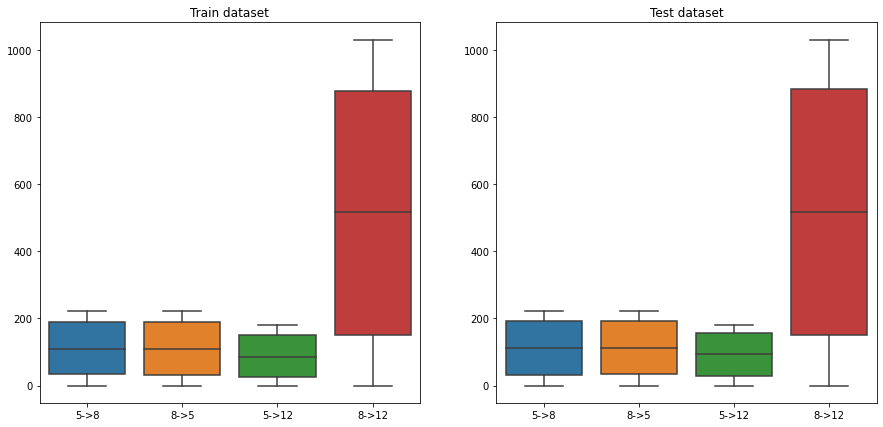

In [75]:
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.boxplot(data=train_df, ax=axs[0])
sns.boxplot(data=test_df, ax=axs[1])
axs[0].set_title('Train dataset')
axs[1].set_title('Test dataset')

In [76]:
def plot_data(target: str):
    fig, axs = plt.subplots(ncols=1, nrows=3, figsize=(30,7))
    sns.scatterplot(data=train_df, x=np.arange(0, train_df.shape[0], 1), y=target, ax=axs[0]).set_title(f"Wizualizacja zbioru treningowego {target}")
    sns.scatterplot(data=test_df, x=np.arange(0, test_df.shape[0], 1), y=target, ax=axs[1]).set_title(f"Wizualizacja zbioru testowego {target}")
    sns.scatterplot(data=df, x=np.arange(0, df.shape[0], 1), y=target, ax=axs[2]).set_title(f"Wizualizacja całego zbioru {target}")

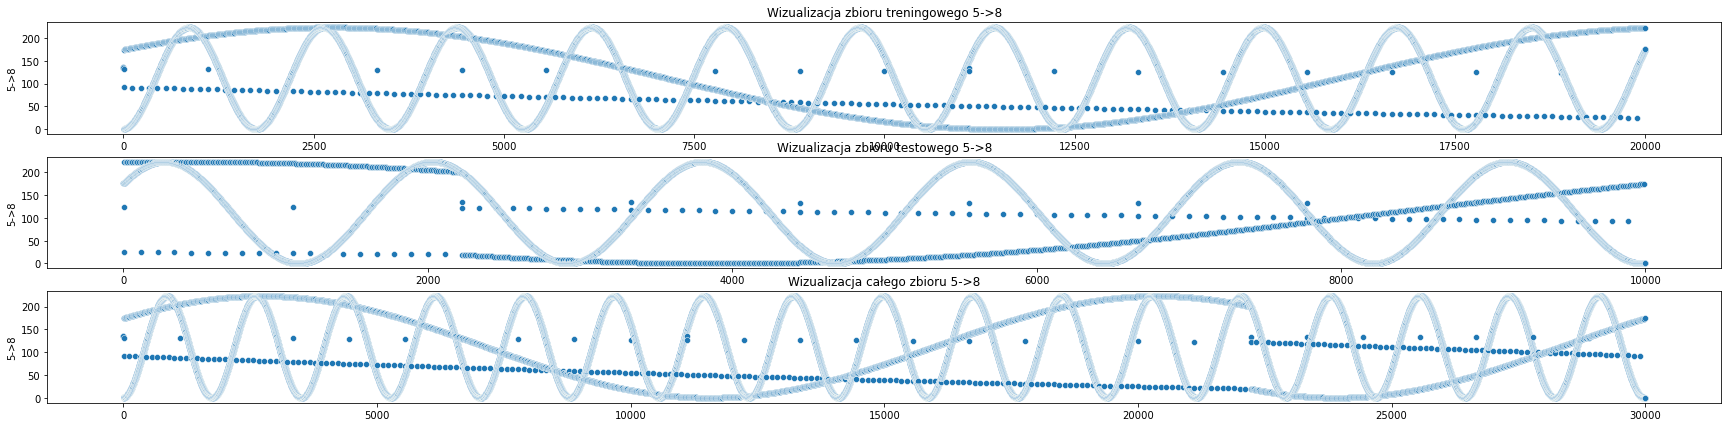

In [77]:
plot_data('5->8')

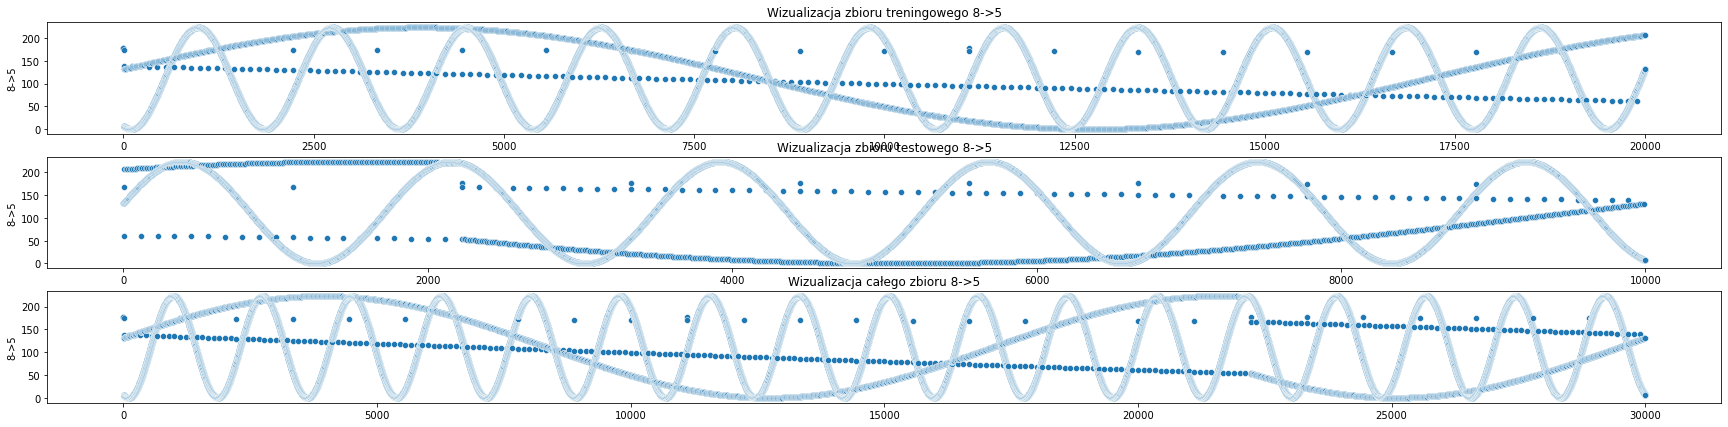

In [78]:
plot_data('8->5')

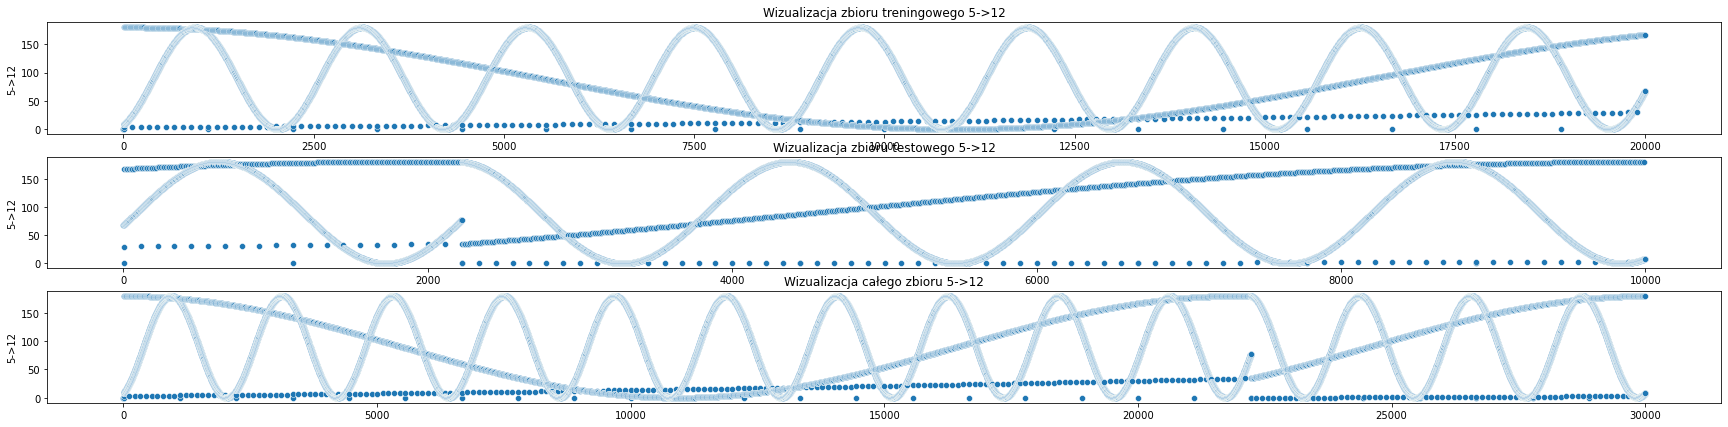

In [79]:
plot_data('5->12')

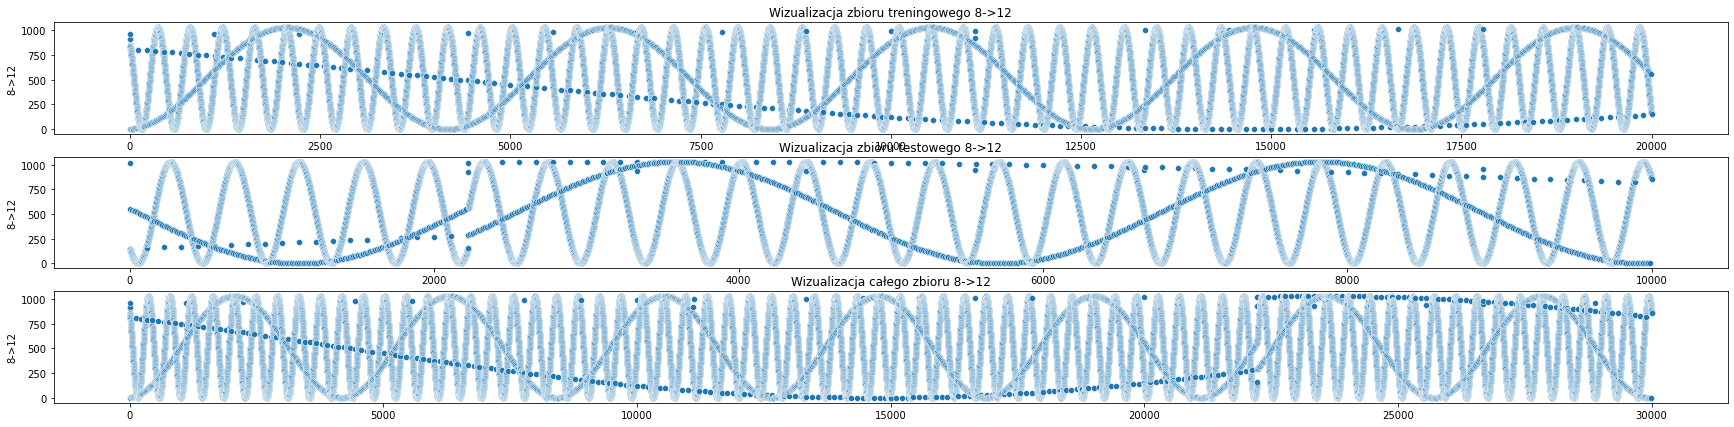

In [80]:
plot_data('8->12')

In [16]:
train_df.describe()

,5->8,8->5,5->12,8->12
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,108.863078,109.012183,88.754259,517.273682
std,78.558593,78.623536,63.871255,364.305883
min,0.000093,0.000073,0.000000,0.009673
25%,30.768800,30.756700,24.533900,155.416750
50%,106.113000,106.131000,87.741250,518.407000
75%,187.304000,187.317000,152.742750,882.491000
max,223.102000,223.102000,179.932000,1030.410000


In [17]:
test_df.describe()

,5->8,8->5,5->12,8->12
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,115.929118,115.064977,89.440779,510.835331
std,79.583216,78.996612,63.279357,365.398214
min,0.000093,0.000073,0.000000,0.009643
25%,35.797450,35.784825,27.146350,143.452750
50%,120.226000,119.174000,87.741150,507.751000
75%,196.181000,193.850000,152.742750,876.481000
max,223.102000,223.102000,179.932000,1030.410000


In [18]:
def split_sequence(*, sequence, n_input_steps=5, n_output_steps=1):
    X, y = list(), list()
    for i in range(sequence.shape[0]):
        if i + n_input_steps + n_output_steps < len(sequence) + 1:
            seq_x, seq_y = list(sequence[i:i+n_input_steps]), list(sequence[i+n_input_steps:i+n_input_steps+n_output_steps])
            X.append(seq_x)
            y.append(seq_y)
    return np.array(X), np.array(y)

In [43]:
n_input_steps = 10
n_output_steps = 5
#target = '5->8'
#target = '8->5'
#target = '5->12'
target = '8->12'
X_train, y_train = split_sequence(sequence = train_df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)
X_test, y_test = split_sequence(sequence = test_df[target], n_input_steps=n_input_steps, n_output_steps=n_output_steps)

In [44]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [45]:

# TODO: Zmodyfikować tworzenie zbioru w taki sposób, aby funkcja train_model sama wybierała poprawny cel tj. '5->8', '8->5' itd.
def build_model(n_input_steps: int, n_output_steps: int, n_features: int, *, model_type: str) -> tf.keras.Model:
    model_types = ['LSTM']
    if model_type in model_types:
        if model_type == 'LSTM':
            model = keras.Sequential()
            model.add(layers.LSTM(50, activation='relu', input_shape=(n_input_steps, n_features)))
            model.add(layers.Dense(n_output_steps))
            model.compile(optimizer='adam', loss='mse')
    else:
        print('Model niedostępny')
        return
    
    return model

# TODO: Dodać podział na zbiór walidacyjny i testowy?
def train_model(input_data: np.array, input_target: str, output_data: np.array, output_target: str, 
                model_type: str, epochs: int = 20, verbose: int = 1, early_stopping: bool = True) -> str:
    n_input_steps = input_data.shape[1]
    n_output_steps = output_data.shape[1]
    n_features = input_data.shape[2]

    models_path = './saved_models/'
    saved_models = os.listdir(models_path)
    model_name = f'{model_type}_{input_target}to{output_target}_in{str(n_input_steps)}_out{str(n_output_steps)}'
    model_path = f'{models_path}{model_name}'
    target = f'{input_target}->{output_target}'

    if model_name not in saved_models:
        es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)
        model = build_model(n_input_steps=n_input_steps, n_output_steps=n_output_steps, n_features=n_features, 
                            model_type=model_type)
        model.fit(input_data, output_data, epochs=20, verbose=1, callbacks=[es])
        model.save(model_path)
        del model

        print('Zakończono trening i zapis modelu ')
        print(f'Wczytano ścieżkę modelu: {model_path}\n')

    else:
        print(f'Model {model_name} już istnieje')
        print(f'Wczytano ścieżkę modelu: {model_path}')
        print('W celu wytrenowania nowego modelu należy ręcznie usunąć zapisane pliki\n')

    return model_path

def test_model(input_data: np.array, output_data: np.array, model_path: str = None, model_type: str = None):
    if model_path is None and model_type is None:
        print('Nie wybrano żadnego modelu')
        print('Podaj ścieżkę do modelu lub wybierz typ modelu')
        return
    elif model_path is not None and model_type is not None:
        print('Wybrano zbyt wiele modeli')
        print('Podaj ścieżkę do modelu lub wybierz typ modelu')
        return

    elif model_path is not None and model_type is None:
        model = tf.keras.models.load_model(model_path)
        y_pred = model.predict(input_data, verbose=0)

    elif model_path is None and model_type is not None:
        return
    

    print(f'MAPE: {mean_absolute_percentage_error(output_data, y_pred)}')
    print(y_pred[:5])
    print(y_test[:5])

    figure = plt.figure(figsize = (20, 15))
    ax = plt.subplot(111)
    line = ax.plot(np.arange(0, output_data.shape[0], 1), output_data, 'r', linewidth=5)
    line2 = ax.plot(np.arange(0, y_pred.shape[0], 1), y_pred, 'b', linewidth=1)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)

    plt.show()

Model LSTM_8to12_in10_out5 już istnieje
Wczytano ścieżkę modelu: ./saved_models/LSTM_8to12_in10_out5
W celu wytrenowania nowego modelu należy ręcznie usunąć zapisane pliki



No handles with labels found to put in legend.


MAPE: 0.10908952972500989
[[80.95342  74.56177  70.50486  64.27012  61.09589 ]
 [74.90945  71.555954 66.915146 58.1702   59.031483]
 [70.81002  67.5544   63.17255  54.285847 55.03646 ]
 [67.065834 63.851727 59.726128 51.50834  51.673546]
 [63.33785  60.232533 56.33867  49.15599  48.53521 ]]
[[81.7467 77.2165 72.7973 68.5065 64.337 ]
 [77.2165 72.7973 68.5065 64.337  60.2826]
 [72.7973 68.5065 64.337  60.2826 56.3593]
 [68.5065 64.337  60.2826 56.3593 52.5537]
 [64.337  60.2826 56.3593 52.5537 48.8809]]


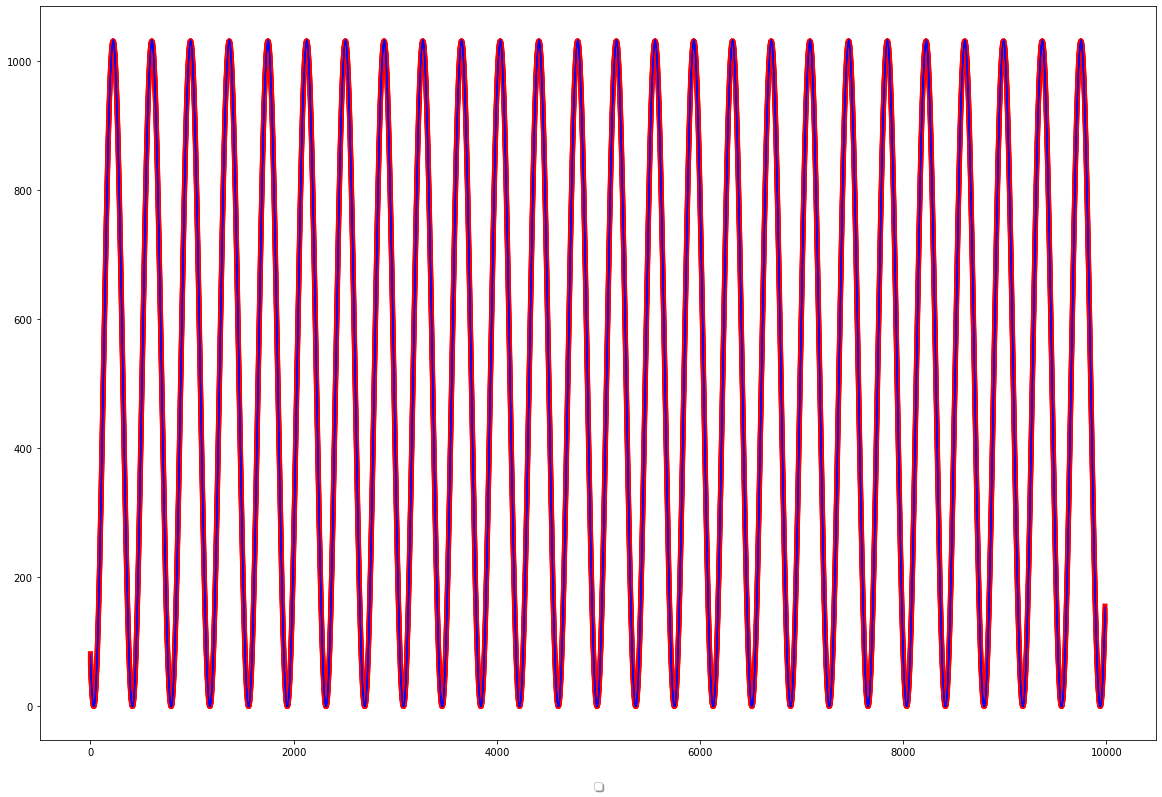

In [46]:
model_path = train_model(input_data=X_train, input_target=8, output_data=y_train, output_target=12, model_type='LSTM')
test_model(input_data=X_test, output_data=y_test, model_path=model_path)

In [47]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train.reshape((X_train.shape[0], X_train.shape[1])), y_train)

In [48]:
reg.coef_

array([[-0.27088079, -0.27122103,  0.19203502, -0.20459987, -0.1349947 ,
         0.70905655,  0.19409911,  0.19784459,  0.3392237 ,  0.24571841],
       [-0.25577569, -0.27246456, -0.16534876,  0.19373429, -0.19066568,
         0.14474399,  0.71822565,  0.18997664,  0.30168618,  0.33070148],
       [-0.33107589, -0.26227595, -0.1340745 , -0.16699245,  0.2092046 ,
         0.17847624,  0.16003471,  0.71638206,  0.32824071,  0.29495756],
       [ 0.08935689, -0.46938557, -0.25811469, -0.24067066, -0.24894692,
         0.32396637,  0.26997323,  0.26553899,  0.7981637 ,  0.46239403],
       [-0.46134205,  0.07970845, -0.27637236, -0.26080996, -0.21943103,
         0.26631777,  0.3456365 ,  0.26783038,  0.45869976,  0.78933495]])

In [49]:
y_pred = reg.predict(X_test.reshape((X_test.shape[0], X_test.shape[1])))

In [50]:
print(f'MAPE: {mean_absolute_percentage_error(y_test, y_pred):.6f}')
# TODO: Dodać dowolną metrykę

MAPE: 0.000190


In [51]:
y_pred

array([[ 81.74511024,  77.2148202 ,  72.79572612,  68.50414144,
         64.33203558],
       [ 77.21501127,  72.79599746,  68.50478868,  64.3324166 ,
         60.28021909],
       [ 72.79706422,  68.5061765 ,  64.3322281 ,  60.28215362,
         56.35925752],
       ...,
       [120.74801109, 126.27362216, 131.89567462, 137.61932111,
        143.45778895],
       [126.27171952, 131.89315775, 137.61844572, 143.45427572,
        149.38391227],
       [131.89520345, 137.62116107, 143.455681  , 149.38770508,
        155.42373345]])

In [52]:
y_test

array([[ 81.7467,  77.2165,  72.7973,  68.5065,  64.337 ],
       [ 77.2165,  72.7973,  68.5065,  64.337 ,  60.2826],
       [ 72.7973,  68.5065,  64.337 ,  60.2826,  56.3593],
       ...,
       [120.743 , 126.278 , 131.899 , 137.624 , 143.452 ],
       [126.278 , 131.899 , 137.624 , 143.452 , 149.38  ],
       [131.899 , 137.624 , 143.452 , 149.38  , 155.43  ]])

In [29]:
#from collections import defaultdict
#from functools import partial

#new_dict = defaultdict(lambda: numpy.zeros(array_size))
#defaultdict(partial(numpy.ndarray, 0))